In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc

/home/yujia/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read 8k/10k data
pbmc6k = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/pbmc6k/filtered_matrices_mex/hg19")
pbmcA = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/donorA/filtered_matrices_mex/hg19")
pbmcB = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/donorB/filtered_matrices_mex/hg19")
pbmcC = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/donorC/filtered_matrices_mex/hg19")

In [3]:
pbmc6k.obs["IID"] = "pbmc6k"
pbmcA.obs["IID"] = "pbmcA"
pbmcB.obs["IID"] = "pbmcB"
pbmcC.obs["IID"] = "pbmcC"

In [4]:
pbmc6k.obs_names=['pbmc6k-'+x for x in pbmc6k.obs_names]
pbmcA.obs_names=['pbmcA-'+x for x in pbmcA.obs_names]
pbmcB.obs_names=['pbmcB-'+x for x in pbmcB.obs_names]
pbmcC.obs_names=['pbmcC-'+x for x in pbmcC.obs_names]

#### PBMC6K

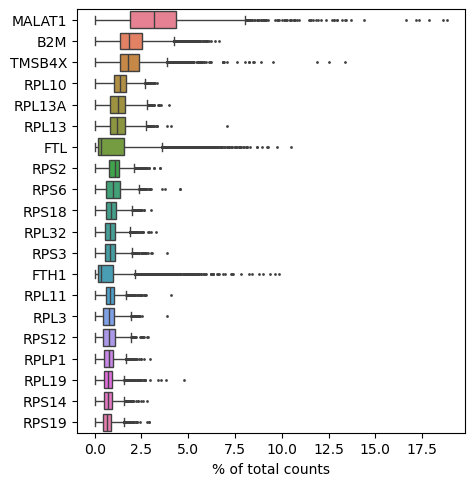

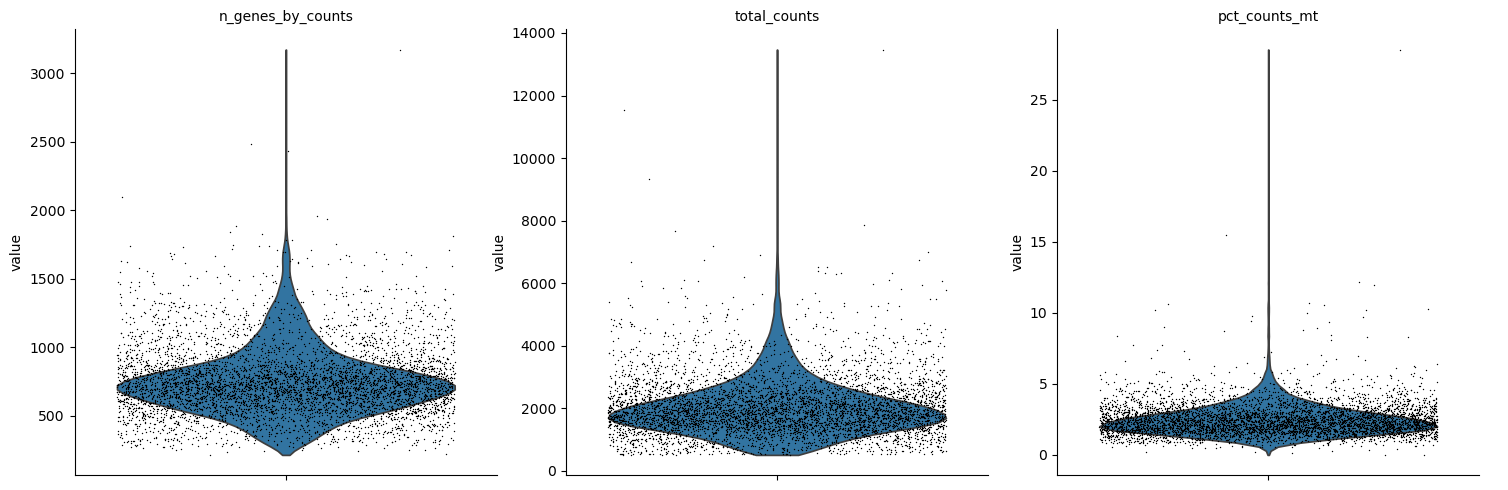

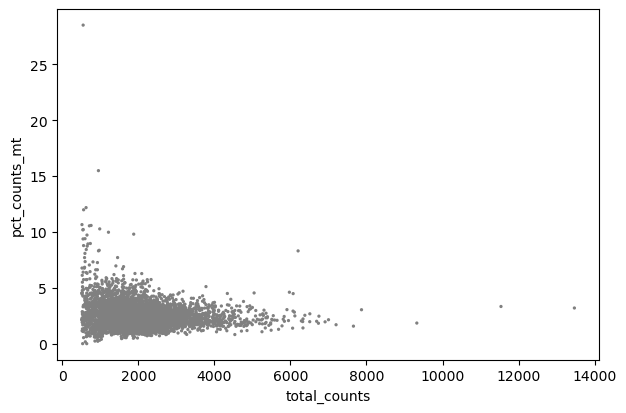

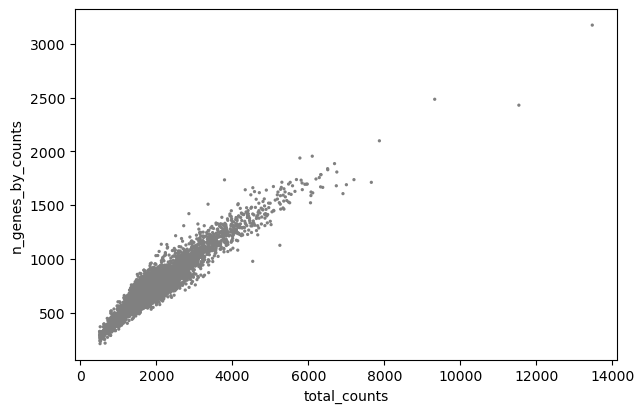

/home/yujia/miniconda3/envs/pytorch/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
sc.pl.highest_expr_genes(pbmc6k, n_top=20)

sc.pp.filter_cells(pbmc6k, min_genes=200)
sc.pp.filter_genes(pbmc6k, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
pbmc6k.var["mt"] = pbmc6k.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    pbmc6k, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pl.violin(
    pbmc6k,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.scatter(pbmc6k, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(pbmc6k, x="total_counts", y="n_genes_by_counts")

pbmc6k = pbmc6k[pbmc6k.obs.n_genes_by_counts < 2500, :]
pbmc6k = pbmc6k[pbmc6k.obs.pct_counts_mt < 5, :].copy()

sc.pp.normalize_total(pbmc6k, target_sum=1e4)

sc.pp.log1p(pbmc6k)

sc.pp.highly_variable_genes(pbmc6k, min_mean=0.0125, max_mean=3, min_disp=0.5)

pbmc6k.raw = pbmc6k

pbmc6k = pbmc6k[:, pbmc6k.var.highly_variable]

sc.pp.regress_out(pbmc6k, ["total_counts", "pct_counts_mt"])

sc.pp.scale(pbmc6k, max_value=10)

sc.tl.pca(pbmc6k, svd_solver="arpack")

# sc.pl.pca(pbmc6k, color="CST3")
# sc.pl.pca_variance_ratio(pbmc6k, log=True)

sc.pp.neighbors(pbmc6k, n_neighbors=10, n_pcs=40)
sc.tl.umap(pbmc6k, n_components=4)

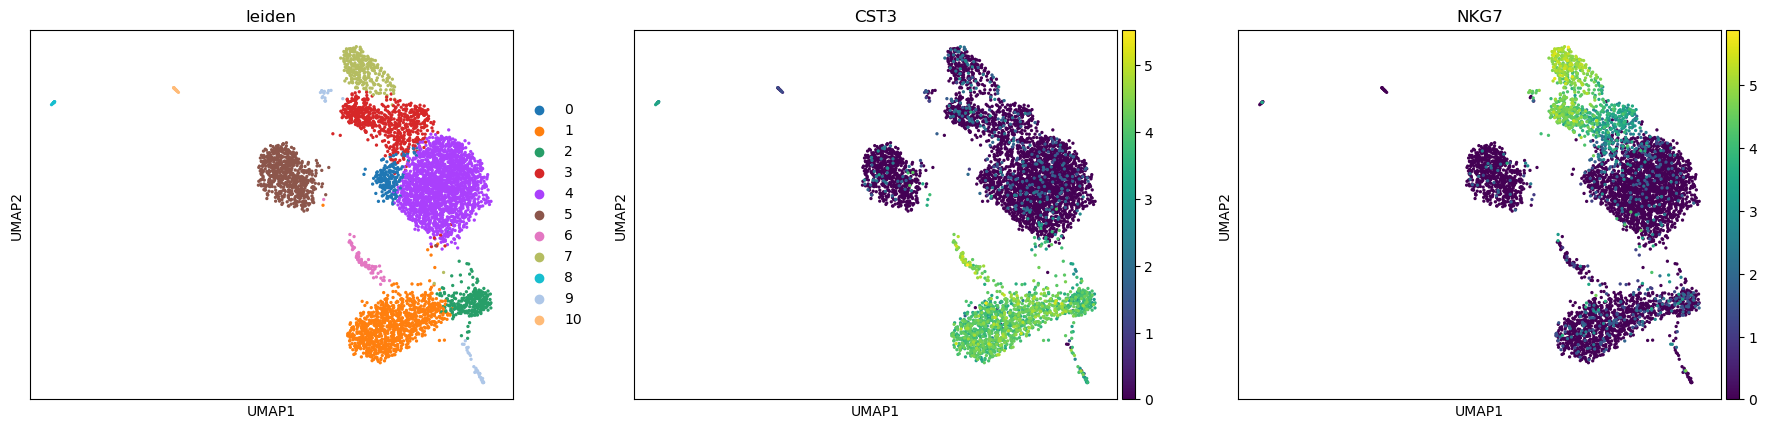

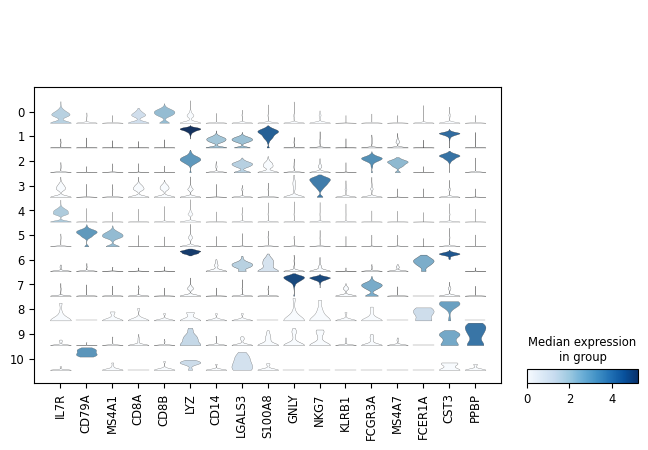

In [6]:
sc.tl.umap(pbmc6k, n_components=2)

sc.tl.leiden(
    pbmc6k,
    resolution=0.8,
    random_state=0,
    flavor="igraph",
    n_iterations=5,
    directed=False,
)

sc.pl.umap(pbmc6k, color=["leiden", "CST3", "NKG7"])

marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]
sc.pl.stacked_violin(pbmc6k, marker_genes, groupby="leiden")

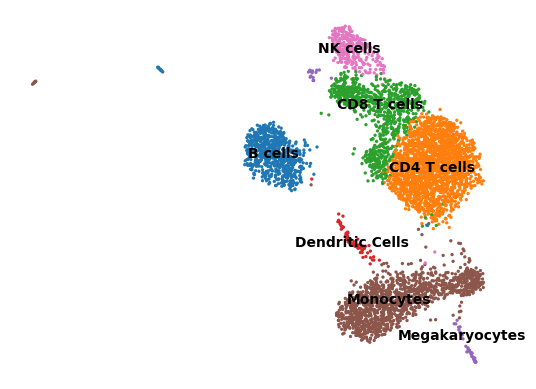

In [7]:
new_cluster_names = {
    "0": "CD8 T cells", # 0
    "1": "Monocytes", # 1 CD14+ Monocytes
    "2": "Monocytes", # 2 FCGR3A+ Monocytes
    "3": "CD8 T cells", # 3 
    "4": "CD4 T cells", # 4
    "5": "B cells", # 5
    "6": "Dendritic Cells", # 6
    "7": "NK cells", # 7
    "8": "Monocytes", # 7 FCGR3A+ Monocytes
    "9": "Megakaryocytes", # 7
    "10": "B cells", # 7
}

pbmc6k.obs["cell_type"] = pbmc6k.obs["leiden"].to_list()
pbmc6k.obs.replace({"cell_type": new_cluster_names}, inplace=True) 
sc.pl.umap(
    pbmc6k, color="cell_type", legend_loc="on data", title="", frameon=False
)

#### PBMCA

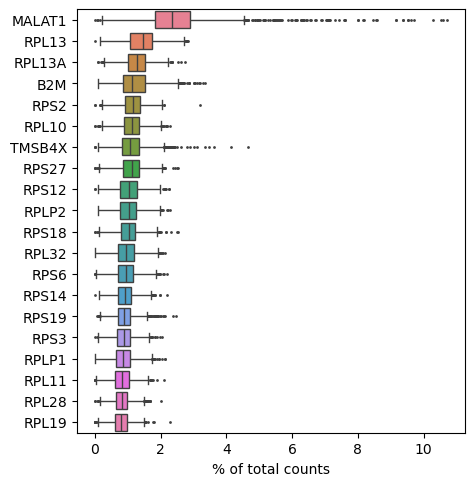

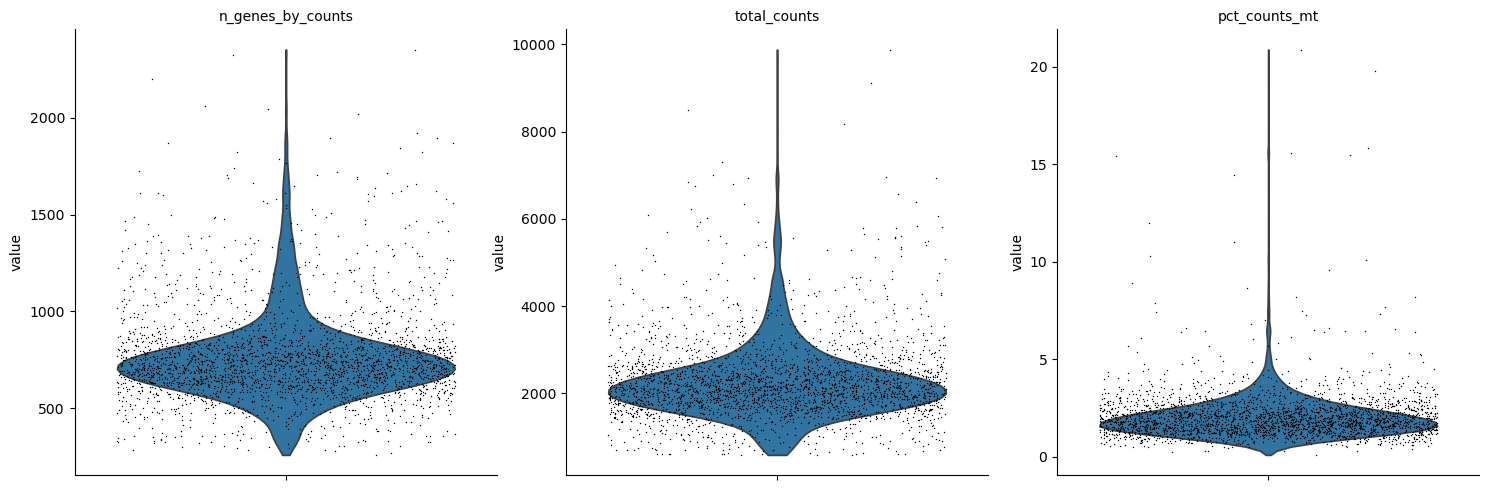

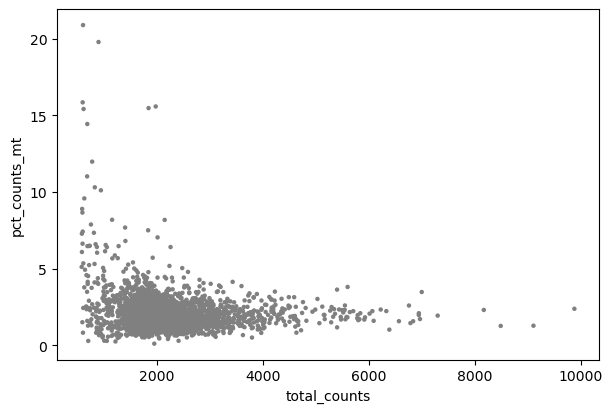

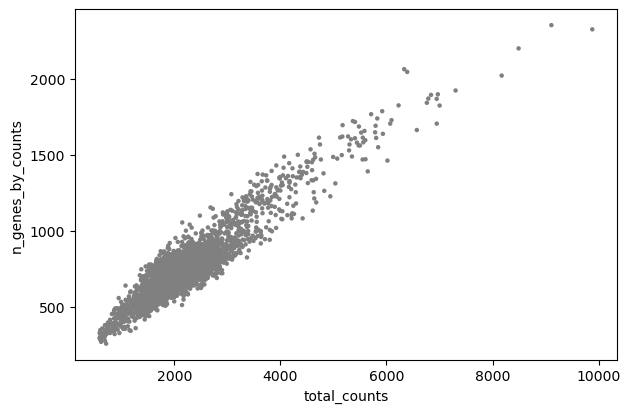

/home/yujia/miniconda3/envs/pytorch/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
sc.pl.highest_expr_genes(pbmcA, n_top=20)

sc.pp.filter_cells(pbmcA, min_genes=200)
sc.pp.filter_genes(pbmcA, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
pbmcA.var["mt"] = pbmcA.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    pbmcA, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pl.violin(
    pbmcA,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.scatter(pbmcA, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(pbmcA, x="total_counts", y="n_genes_by_counts")

pbmcA = pbmcA[pbmcA.obs.n_genes_by_counts < 2000, :]
pbmcA = pbmcA[pbmcA.obs.pct_counts_mt < 5, :].copy()

sc.pp.normalize_total(pbmcA, target_sum=1e4)

sc.pp.log1p(pbmcA)

sc.pp.highly_variable_genes(pbmcA, min_mean=0.0125, max_mean=3, min_disp=0.5)

pbmcA.raw = pbmcA

pbmcA = pbmcA[:, pbmcA.var.highly_variable]

sc.pp.regress_out(pbmcA, ["total_counts", "pct_counts_mt"])

sc.pp.scale(pbmcA, max_value=10)

sc.tl.pca(pbmcA, svd_solver="arpack")

# sc.pl.pca(pbmcA, color="CST3")
# sc.pl.pca_variance_ratio(pbmcA, log=True)

sc.pp.neighbors(pbmcA, n_neighbors=10, n_pcs=40)
sc.tl.umap(pbmcA, n_components=4)

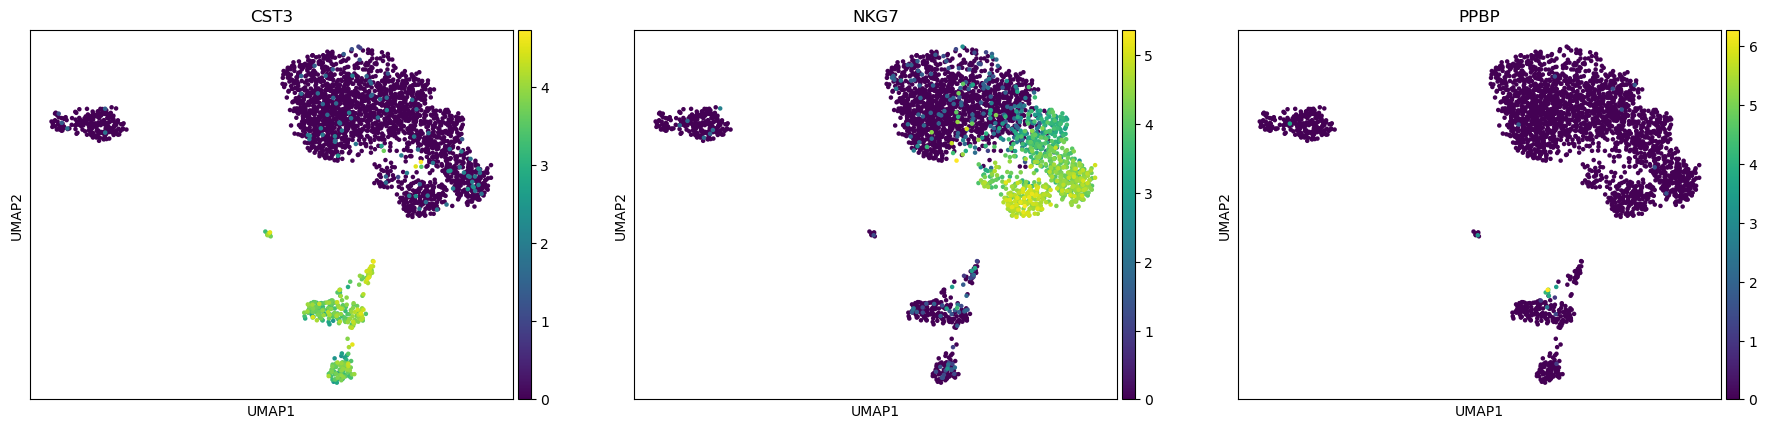

In [9]:
sc.tl.umap(pbmcA, n_components=2)
sc.pl.umap(pbmcA, color=["CST3", "NKG7", "PPBP"])

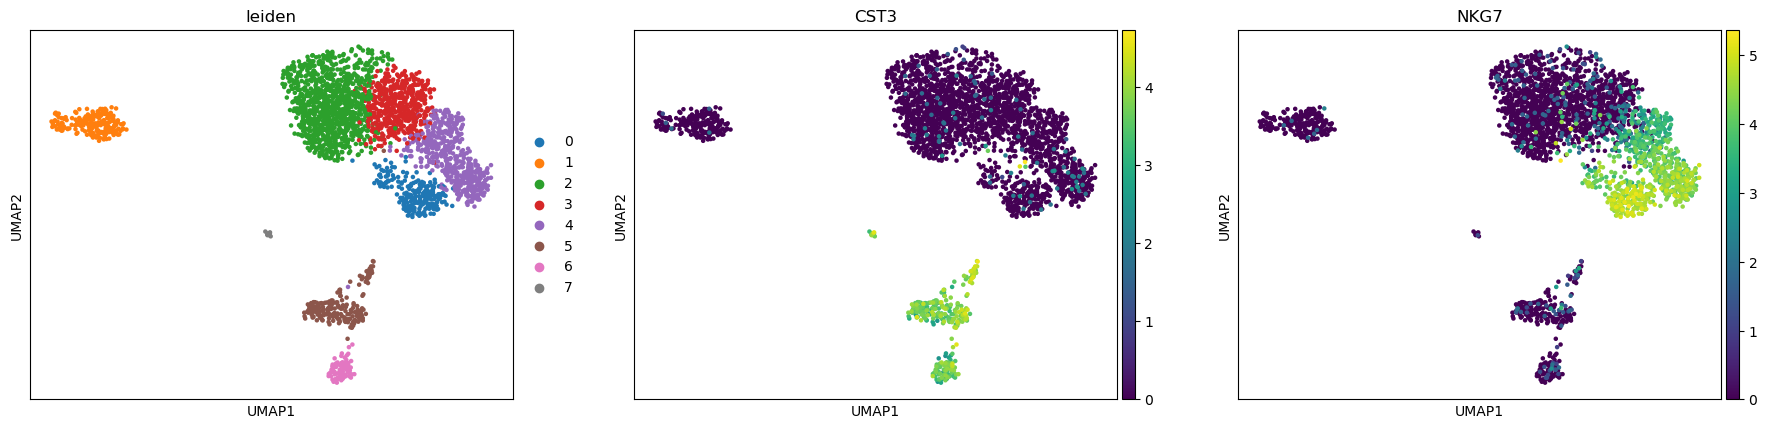

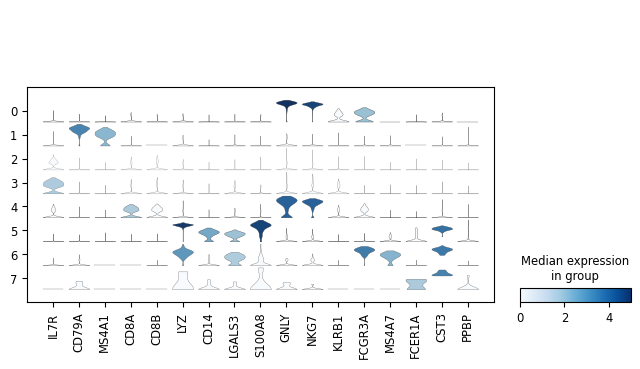

In [10]:
sc.tl.leiden(
    pbmcA,
    resolution=0.5,
    random_state=0,
    flavor="igraph",
    n_iterations=5,
    directed=False,
)
sc.pl.umap(pbmcA, color=["leiden", "CST3", "NKG7"])
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]
sc.pl.stacked_violin(pbmcA, marker_genes, groupby="leiden")


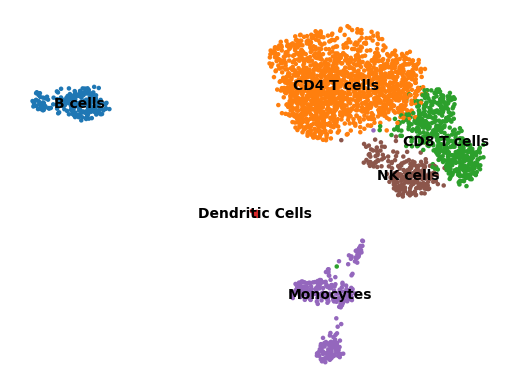

In [11]:
new_cluster_names = {
    "0": "NK cells", # 0
    "1": "B cells", # 1 
    "2": "CD4 T cells", # 2 
    "3": "CD4 T cells", # 3 
    "4": "CD8 T cells", # 4
    "5": "Monocytes", # 5 CD14+ Monocytes
    "6": "Monocytes", # 6 FCGR3A+ Monocytes
    "7": "Dendritic Cells", # 7 
}

pbmcA.obs["cell_type"] = pbmcA.obs["leiden"].to_list()
pbmcA.obs.replace({"cell_type": new_cluster_names}, inplace=True) 
sc.pl.umap(
    pbmcA, color="cell_type", legend_loc="on data", title="", frameon=False
)

#### PBMCB

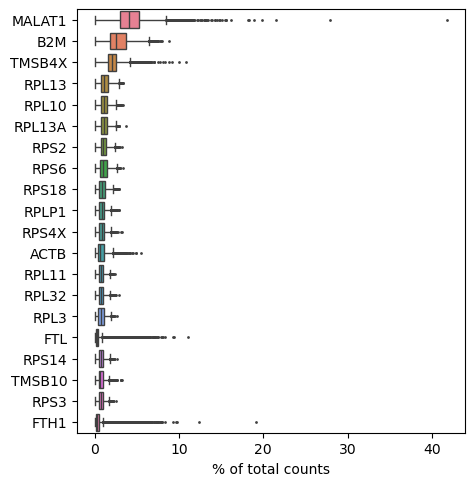

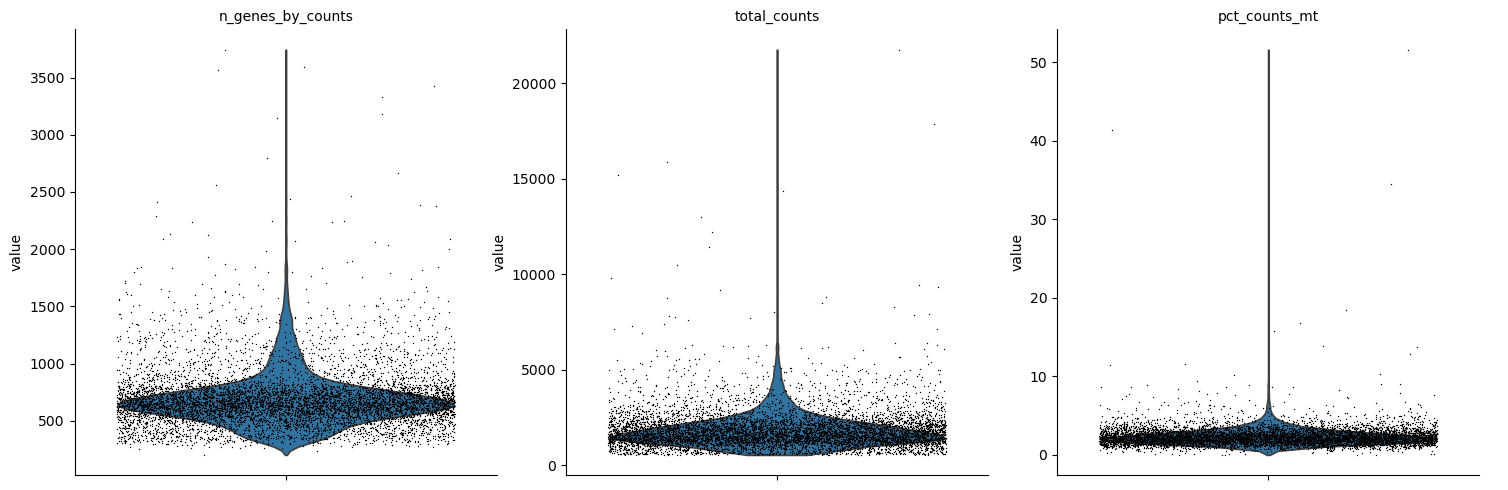

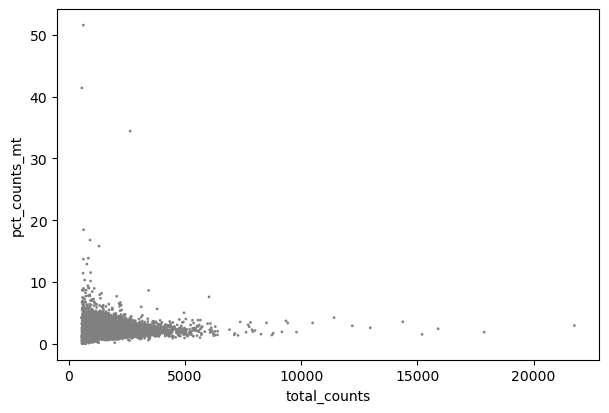

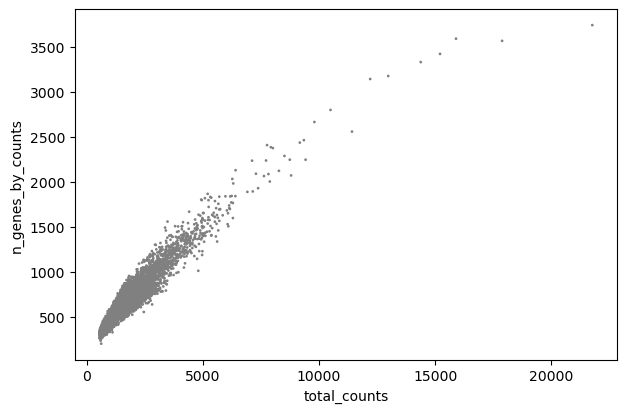

/home/yujia/miniconda3/envs/pytorch/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
sc.pl.highest_expr_genes(pbmcB, n_top=20)

sc.pp.filter_cells(pbmcB, min_genes=200)
sc.pp.filter_genes(pbmcB, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
pbmcB.var["mt"] = pbmcB.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    pbmcB, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pl.violin(
    pbmcB,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.scatter(pbmcB, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(pbmcB, x="total_counts", y="n_genes_by_counts")

pbmcB = pbmcB[pbmcB.obs.n_genes_by_counts < 2000, :]
pbmcB = pbmcB[pbmcB.obs.pct_counts_mt < 10, :].copy()

sc.pp.normalize_total(pbmcB, target_sum=1e4)

sc.pp.log1p(pbmcB)

sc.pp.highly_variable_genes(pbmcB, min_mean=0.0125, max_mean=3, min_disp=0.5)

pbmcB.raw = pbmcB

pbmcB = pbmcB[:, pbmcB.var.highly_variable]

sc.pp.regress_out(pbmcB, ["total_counts", "pct_counts_mt"])

sc.pp.scale(pbmcB, max_value=10)

sc.tl.pca(pbmcB, svd_solver="arpack")

# sc.pl.pca(pbmcB, color="CST3")
# sc.pl.pca_variance_ratio(pbmcB, log=True)

sc.pp.neighbors(pbmcB, n_neighbors=10, n_pcs=40)
sc.tl.umap(pbmcB, n_components=4)

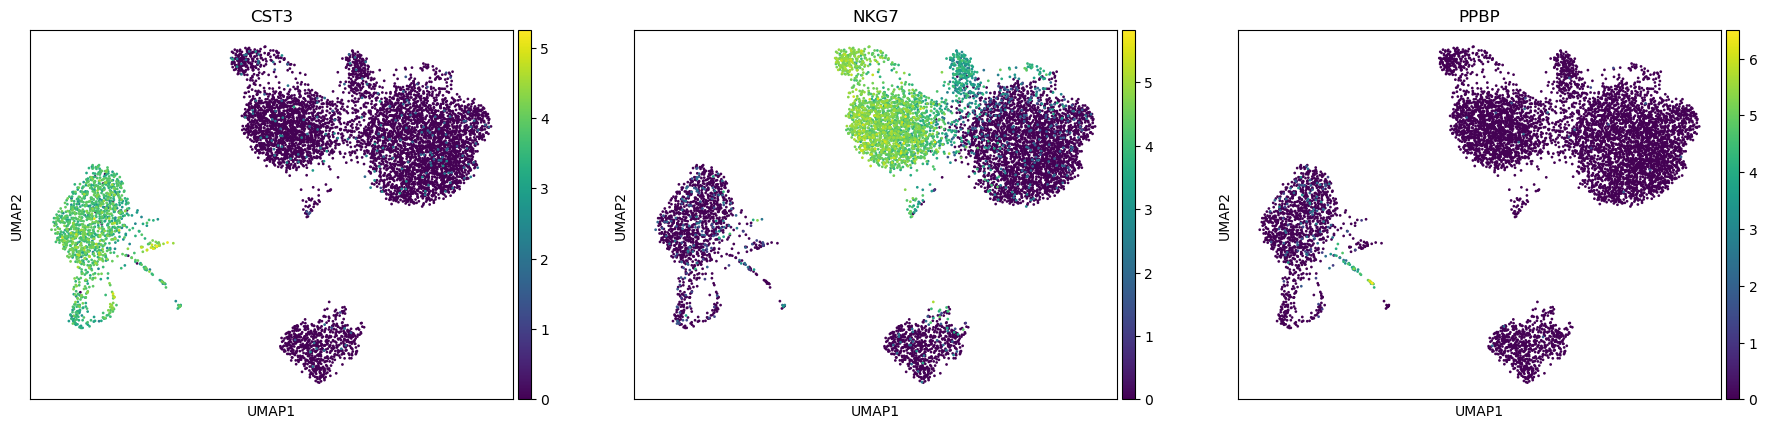

In [13]:
sc.tl.umap(pbmcB, n_components=2)
sc.pl.umap(pbmcB, color=["CST3", "NKG7", "PPBP"])

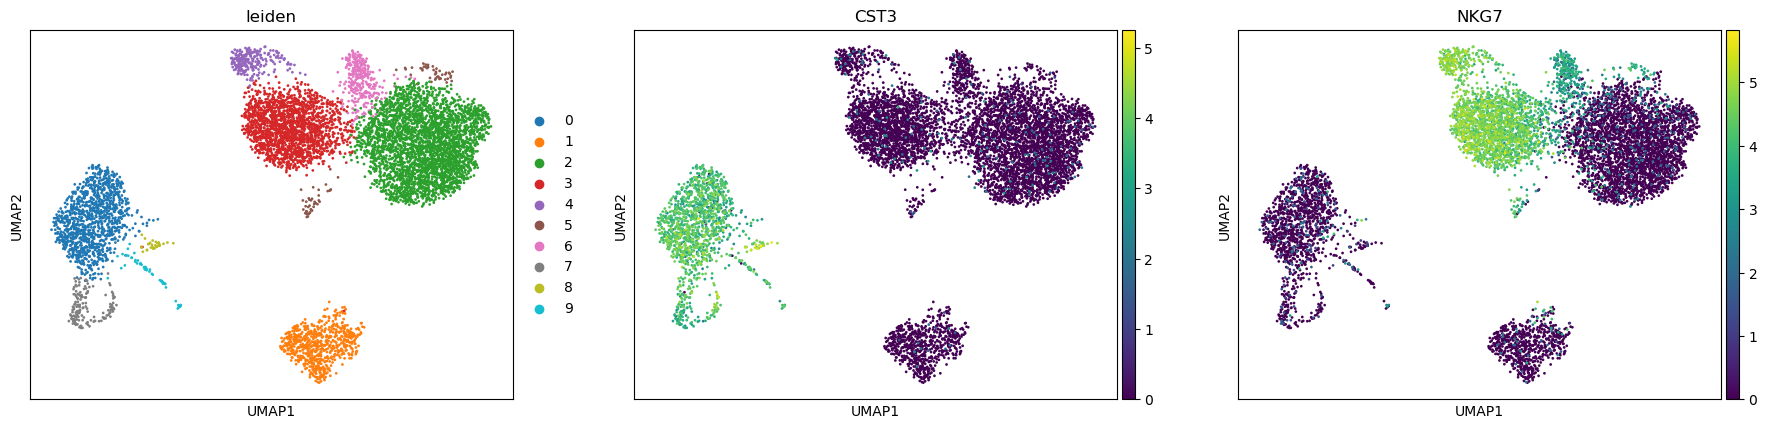

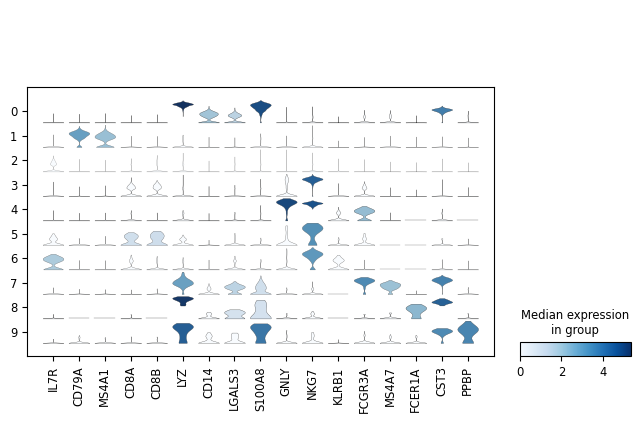

In [14]:
sc.tl.leiden(
    pbmcB,
    resolution=0.5,
    random_state=0,
    flavor="igraph",
    n_iterations=5,
    directed=False,
)
sc.pl.umap(pbmcB, color=["leiden", "CST3", "NKG7"])
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]
sc.pl.stacked_violin(pbmcB, marker_genes, groupby="leiden")

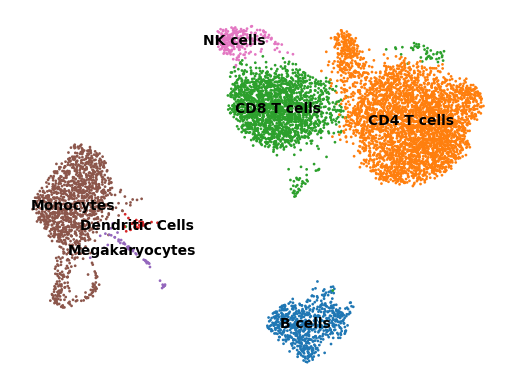

In [15]:
new_cluster_names = {
    "0": "Monocytes", # 0 CD14+ Monocytes
    "1": "B cells", # 1 
    "2": "CD4 T cells", # 2 
    "3": "CD8 T cells", # 3 
    "4": "NK cells", # 4
    "5": "CD8 T cells", # 5
    "6": "CD4 T cells", # 6
    "7": "Monocytes", # 7 FCGR3A+ Monocytes
    "8": "Dendritic Cells", # 8 
    "9": "Megakaryocytes", # 9 
}

pbmcB.obs["cell_type"] = pbmcB.obs["leiden"].to_list()
pbmcB.obs.replace({"cell_type": new_cluster_names}, inplace=True) 
sc.pl.umap(
    pbmcB, color="cell_type", legend_loc="on data", title="", frameon=False
)

#### PBMCC

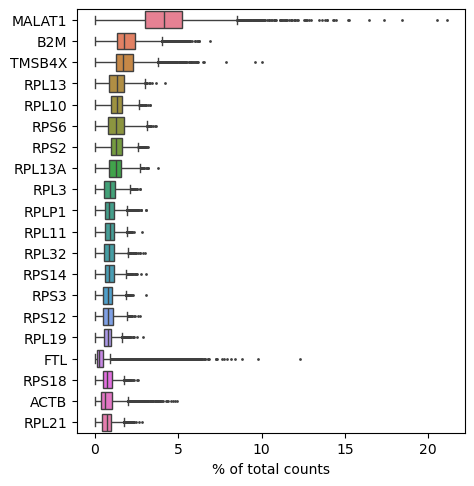

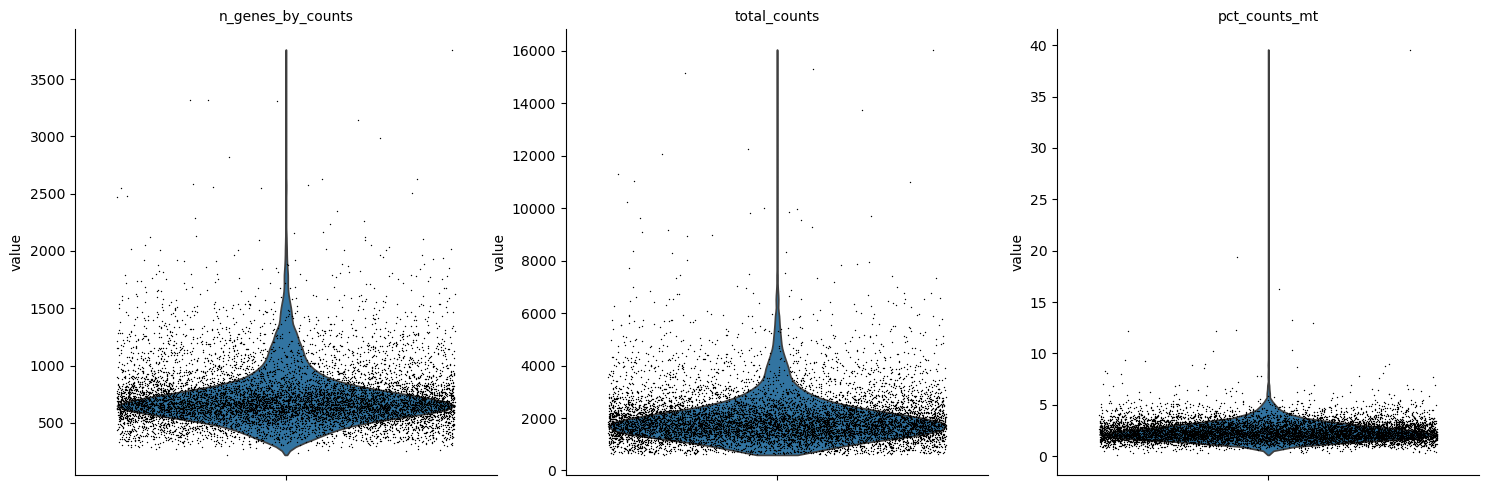

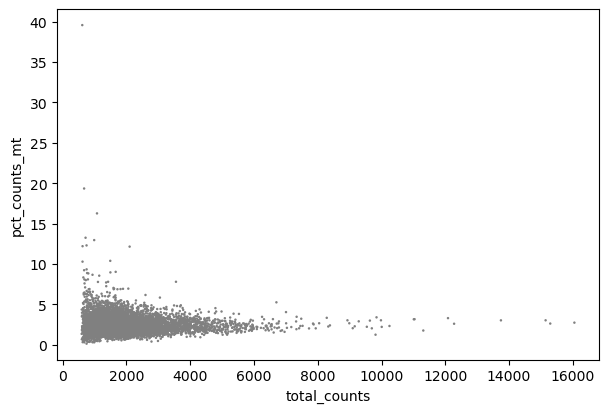

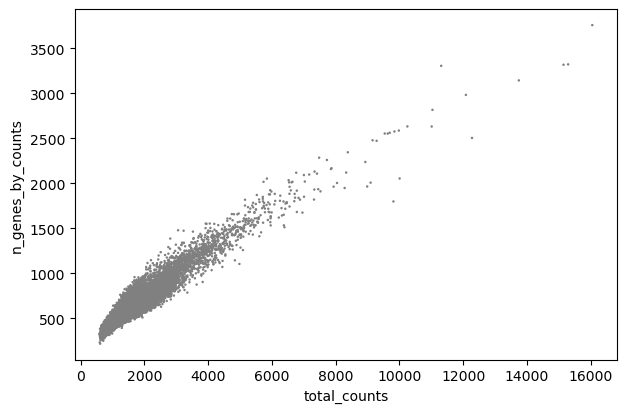

/home/yujia/miniconda3/envs/pytorch/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
sc.pl.highest_expr_genes(pbmcC, n_top=20)

sc.pp.filter_cells(pbmcC, min_genes=200)
sc.pp.filter_genes(pbmcC, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
pbmcC.var["mt"] = pbmcC.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    pbmcC, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pl.violin(
    pbmcC,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.scatter(pbmcC, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(pbmcC, x="total_counts", y="n_genes_by_counts")

pbmcC = pbmcC[pbmcC.obs.n_genes_by_counts < 2000, :]
pbmcC = pbmcC[pbmcC.obs.pct_counts_mt < 5, :].copy()

sc.pp.normalize_total(pbmcC, target_sum=1e4)

sc.pp.log1p(pbmcC)

sc.pp.highly_variable_genes(pbmcC, min_mean=0.0125, max_mean=3, min_disp=0.5)

pbmcC.raw = pbmcC

pbmcC = pbmcC[:, pbmcC.var.highly_variable]

sc.pp.regress_out(pbmcC, ["total_counts", "pct_counts_mt"])

sc.pp.scale(pbmcC, max_value=10)

sc.tl.pca(pbmcC, svd_solver="arpack")

# sc.pl.pca(pbmcC, color="CST3")
# sc.pl.pca_variance_ratio(pbmcC, log=True)

sc.pp.neighbors(pbmcC, n_neighbors=10, n_pcs=40)
sc.tl.umap(pbmcC, n_components=4)

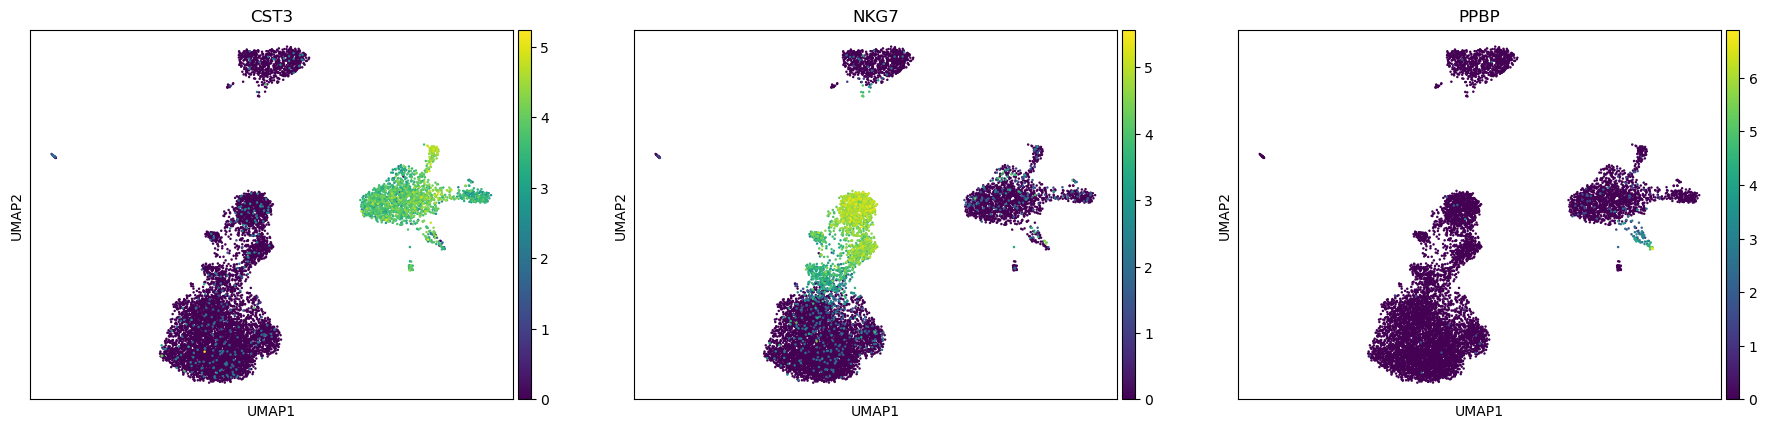

In [17]:
sc.tl.umap(pbmcC, n_components=2)
sc.pl.umap(pbmcC, color=["CST3", "NKG7", "PPBP"])

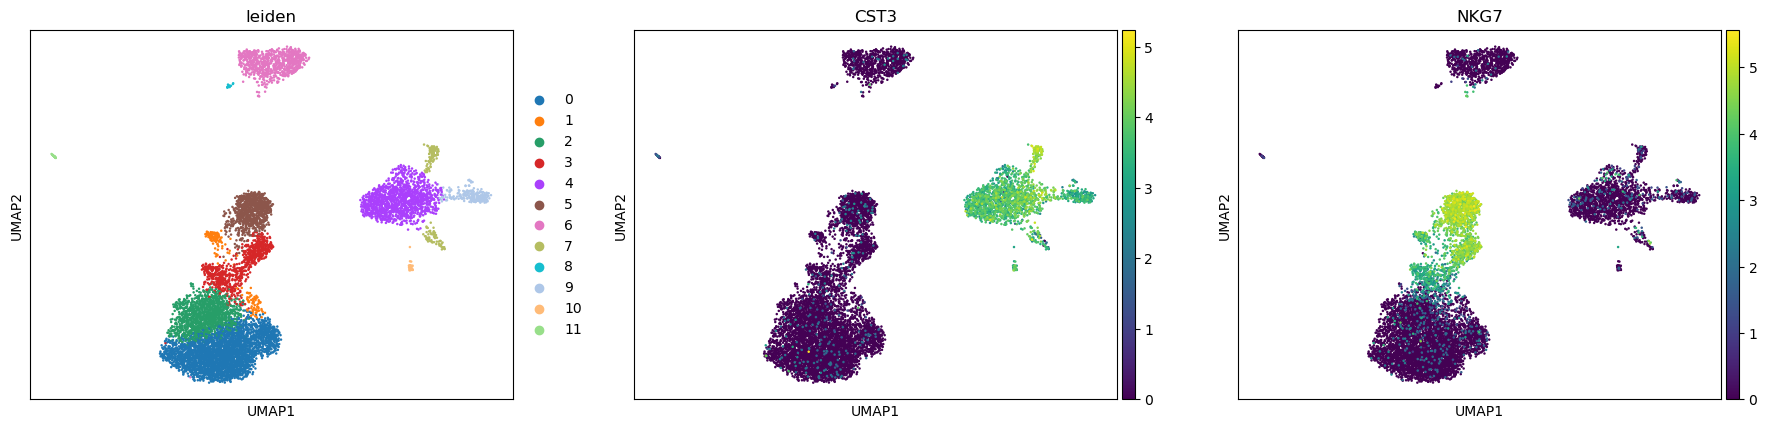

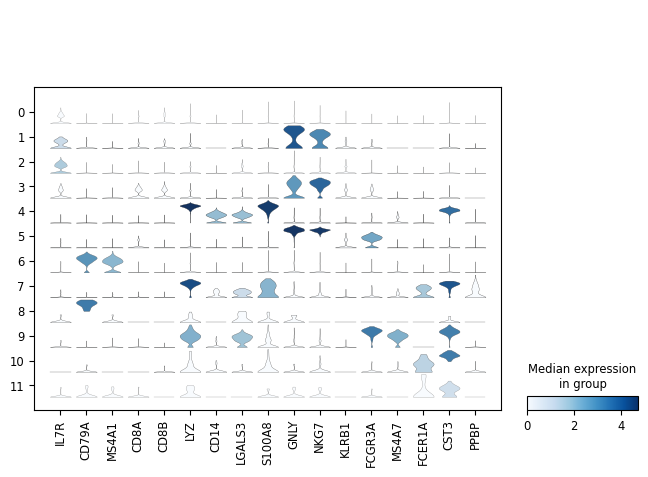

In [18]:
sc.tl.leiden(
    pbmcC,
    resolution=0.6,
    random_state=0,
    flavor="igraph",
    n_iterations=5,
    directed=False,
)
sc.pl.umap(pbmcC, color=["leiden", "CST3", "NKG7"])
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]
sc.pl.stacked_violin(pbmcC, marker_genes, groupby="leiden")

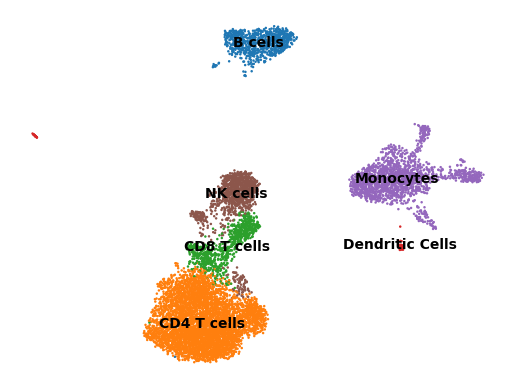

In [19]:
new_cluster_names = {
    "0": "CD4 T cells", # 0
    "1": "NK cells", # 1 
    "2": "CD4 T cells", # 2 
    "3": "CD8 T cells", # 3 
    "4": "Monocytes", # 4
    "5": "NK cells", # 5
    "6": "B cells", # 6
    "7": "Monocytes", # 7 
    "8": "B cells", # 8 
    "9": "Monocytes", # 9 
    "10": "Dendritic Cells", # 10 
    "11": "Dendritic Cells", # 11 
}

pbmcC.obs["cell_type"] = pbmcC.obs["leiden"].to_list()
pbmcC.obs.replace({"cell_type": new_cluster_names}, inplace=True) 
sc.pl.umap(
    pbmcC, color="cell_type", legend_loc="on data", title="", frameon=False
)

In [20]:
# Writs results
pbmcA.obs.to_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/ABC6k/meta_pbmcA.csv")
pbmcB.obs.to_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/ABC6k/meta_pbmcB.csv")
pbmcC.obs.to_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/ABC6k/meta_pbmcC.csv")
pbmc6k.obs.to_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/ABC6k/meta_pbmc6k.csv")

In [29]:
# read 8k/10k data
pbmc6k = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/pbmc6k/filtered_matrices_mex/hg19")
pbmcA = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/donorA/filtered_matrices_mex/hg19")
pbmcB = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/donorB/filtered_matrices_mex/hg19")
pbmcC = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/donorC/filtered_matrices_mex/hg19")

pbmc6k.obs["IID"] = "pbmc6k"
pbmcA.obs["IID"] = "pbmcA"
pbmcB.obs["IID"] = "pbmcB"
pbmcC.obs["IID"] = "pbmcC"

pbmc6k.obs_names=['pbmc6k-'+x for x in pbmc6k.obs_names]
pbmcA.obs_names=['pbmcA-'+x for x in pbmcA.obs_names]
pbmcB.obs_names=['pbmcB-'+x for x in pbmcB.obs_names]
pbmcC.obs_names=['pbmcC-'+x for x in pbmcC.obs_names]

pbmc6k_meta = pd.read_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/ABC6k/meta_pbmc6k.csv")
pbmcA_meta = pd.read_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/ABC6k/meta_pbmcA.csv")
pbmcB_meta = pd.read_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/ABC6k/meta_pbmcB.csv")
pbmcC_meta = pd.read_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/ABC6k/meta_pbmcC.csv")

In [30]:
pbmc6k = pbmc6k[pbmc6k.obs.index.isin(pbmc6k_meta["Unnamed: 0"])]
pbmcA = pbmcA[pbmcA.obs.index.isin(pbmcA_meta["Unnamed: 0"])]
pbmcB = pbmcB[pbmcB.obs.index.isin(pbmcB_meta["Unnamed: 0"])]
pbmcC = pbmcC[pbmcC.obs.index.isin(pbmcC_meta["Unnamed: 0"])]

In [36]:
pbmc6k_meta.index = pbmc6k_meta["Unnamed: 0"]
pbmcA_meta.index = pbmcA_meta["Unnamed: 0"]
pbmcB_meta.index = pbmcB_meta["Unnamed: 0"]
pbmcC_meta.index = pbmcC_meta["Unnamed: 0"]

In [38]:
pbmcA_meta.index.name = None
pbmcB_meta.index.name = None
pbmcC_meta.index.name = None
pbmc6k_meta.index.name = None

In [40]:
pbmc6k.obs = pbmc6k_meta
pbmcA.obs = pbmcA_meta
pbmcB.obs = pbmcB_meta
pbmcC.obs = pbmcC_meta

In [43]:
pbmc = sc.concat([pbmc6k, pbmcA, pbmcB, pbmcC])

In [45]:
pbmc.write_h5ad("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/ABC6k/pbmcABC6k.h5ad")